# Objectives

* Take **ModelNet 10** dataset and test Machine Learning methods to predict 3D objects from point cloud or voxels.
    * [Dataset from kaggle](https://www.kaggle.com/datasets/balraj98/modelnet10-princeton-3d-object-dataset)
* Learn how to handle unordered data from 3D objects.
* Find a methods to be used in point cloud data from Radar, Lidar, etc.

# Libraries

In [1]:
import os

import pandas as pd
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import tensorflow as tf

from keras import callbacks, optimizers, layers, \
    models, initializers, mixed_precision

from mpl_toolkits.mplot3d import Axes3D
from pyntcloud import PyntCloud
from pyntcloud.structures import VoxelGrid

SEED = 40

np.random.seed(SEED)
tf.random.set_seed(SEED)

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2024-08-15 09:43:45.564301: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-15 09:43:45.932100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 09:43:46.054508: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 09:43:46.090332: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-15 09:43:46.323952: I tensorflow/core/platform/cpu_feature_guar

# Constants

In [2]:
BASE_MODEL_DIR = 'datasets/modelnet10/ModelNet10'
META_DATA_PATH = 'datasets/modelnet10/metadata_modelnet10.csv'

# Loading Metadata

In [3]:
metadata = pd.read_csv(META_DATA_PATH)
metadata.head()

,object_id,class,split,object_path
0,bathtub_0107,bathtub,test,bathtub/test/bathtub_0107.off
1,bathtub_0108,bathtub,test,bathtub/test/bathtub_0108.off
2,bathtub_0109,bathtub,test,bathtub/test/bathtub_0109.off
3,bathtub_0110,bathtub,test,bathtub/test/bathtub_0110.off
4,bathtub_0111,bathtub,test,bathtub/test/bathtub_0111.off


# Parsing a sample

In [17]:
def read_off(shape_filename):
    with open(os.path.join(BASE_MODEL_DIR, shape_filename), 'r') as file:
    
        if 'OFF' != file.readline().strip():
            raise('Not a valid OFF header')
        n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
        verts = [[float(s) for s in file.readline().strip().split(' ')] for _ in range(n_verts)]
        faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for _ in range(n_faces)]
        file.close()
        
        return np.array(verts), np.array(faces)

In [18]:
index = np.random.randint(0, metadata.shape[0])

shape_filename = metadata.object_path[index]
label = metadata["class"][index]

verts, faces = read_off(shape_filename)

print(label)
print(verts.shape)
print(faces.shape)

sofa
(308, 3)
(372, 3)


In [19]:
def get_point_cloud(filename, num_points=1024) -> PyntCloud:
    pointcloud = PyntCloud.from_file(os.path.join(BASE_MODEL_DIR, filename))
    # TODO: Add a point sample to fix number of points.
    return pointcloud

def get_voxel_grid(point_cloud: PyntCloud, voxel_shape: tuple[int, int, int] = (32, 32, 32)) -> VoxelGrid:
    voxelgrid_id = point_cloud.add_structure("voxelgrid", n_x=voxel_shape[0], n_y=voxel_shape[1], n_z=voxel_shape[2])
    return point_cloud.structures[voxelgrid_id]

def create_voxels_as_cubes(voxelgrid: VoxelGrid) -> np.ndarray:
    density_feature_vector = voxelgrid.get_feature_vector(mode="density")
    max_density = density_feature_vector.max()
    x_cube_pos = voxelgrid.voxel_x
    y_cube_pos = voxelgrid.voxel_y
    z_cube_pos = voxelgrid.voxel_z

    grid_shape = voxelgrid.x_y_z
    grid = np.zeros((grid_shape[0], grid_shape[1], grid_shape[2], 3))

    for idx in range(0, len(voxelgrid.voxel_n)):
        curr_density = density_feature_vector[x_cube_pos[idx],y_cube_pos[idx],z_cube_pos[idx]]
        curr_density_normalized = curr_density / max_density
        grid[x_cube_pos[idx], y_cube_pos[idx], z_cube_pos[idx]] = (curr_density_normalized, curr_density_normalized, curr_density_normalized)

    return grid

pc = get_point_cloud(shape_filename)
voxelgrid = get_voxel_grid(pc)

# Visualizing single sample

In [20]:
def plot_point_cloud_open3d(point_cloud: PyntCloud, label="Point Cloud", window_size=(800, 600)):
    o3d.visualization.draw_geometries([point_cloud.to_instance("open3d", mesh=False)], 
                                      window_name=label, width=window_size[0], height=window_size[1])
    return

# plot_point_cloud_open3d(pc, label=label)

def plot_voxelgrid_open3d(voxelgrid: VoxelGrid, label="Voxel Visualization"):
    # We extract the density feature for each occupied voxel that we will use for coloring the voxels
    density_feature_vector = voxelgrid.get_feature_vector(mode="density")

    # Calculate the maximum density to normalize the colors
    max_density = density_feature_vector.max()

    # We extract the shape of a voxel, as well as the position of each point in X, Y, Z in the voxel grid
    voxel_size = voxelgrid.shape
    x_cube_pos = voxelgrid.voxel_x
    y_cube_pos = voxelgrid.voxel_y
    z_cube_pos = voxelgrid.voxel_z

    # Initialize a open3d triangle mesh object
    vox_mesh = o3d.geometry.TriangleMesh()

    # go through all voxelgrid voxels
    for idx in range(0, len(voxelgrid.voxel_n)):
        # get the id of the current voxel in the voxel grid
        curr_number = voxelgrid.voxel_n[idx]
        # get the center of the voxel grid voxel
        voxel_center = voxelgrid.voxel_centers[curr_number]
        # get the density value of the current voxel. Because the density matrix is in the shape X,Y,Z, where they are the coordinates in the voxel grid
        # we use the voxel grid positions we already
        curr_density = density_feature_vector[x_cube_pos[idx],y_cube_pos[idx],z_cube_pos[idx]]
        # we normalize the value using the maximum density
        curr_density_normalized = curr_density / max_density
        # create a box primitive in open3d
        primitive=o3d.geometry.TriangleMesh.create_box(width=1, height=1, depth=1)
        # paint the box uniformly using the normalized density
        primitive.paint_uniform_color((curr_density_normalized,curr_density_normalized,curr_density_normalized))
        # scale the cube using the saved voxel size
        primitive.scale(voxel_size[0], center=primitive.get_center())
        # we translate the box to the center position of the voxel
        primitive.translate(voxel_center, relative=True)
        # add to the voxel mesh
        vox_mesh+=primitive

    # Initialize a visualizer object
    vis = o3d.visualization.Visualizer()
    # Create a window, name it and scale it
    vis.create_window(window_name=label, width=800, height=600)
    # add the voxel mesh to the visualizer
    vis.add_geometry(vox_mesh)
    vis.run()
    # Once the visualizer is closed destroy the window and clean up
    vis.destroy_window()

    return

# plot_voxelgrid_open3d(voxelgrid, label=label)

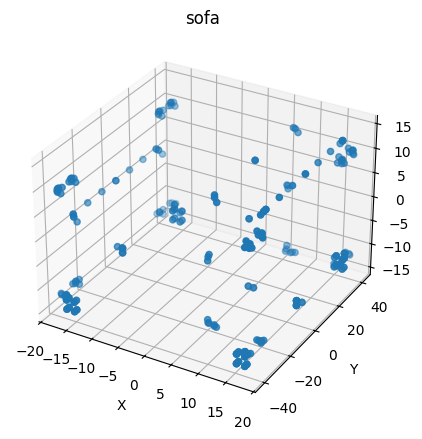

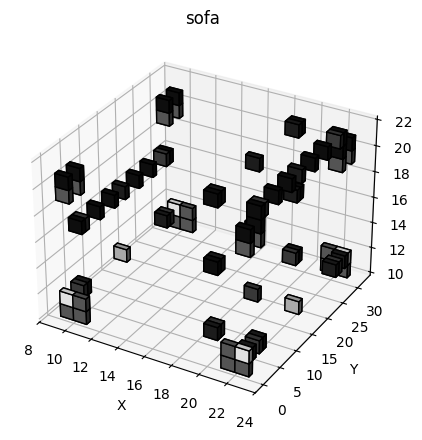

In [21]:
def plot_point_cloud_matplotlib(point_cloud: PyntCloud, label="Point Cloud", figsize=(10, 5)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(point_cloud.xyz[:, 0], point_cloud.xyz[:, 1], point_cloud.xyz[:, 2], marker="o")
    ax.set_title(label)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()
    return

plot_point_cloud_matplotlib(pc, label=label)

def plot_voxelgrid_matplotlib(voxelgrid: VoxelGrid, label="Point Cloud", figsize=(10, 5)):
    voxel = create_voxels_as_cubes(voxelgrid)
    grid = voxel[:, :, :, 0]
    color = voxel

    ax = plt.figure(figsize=figsize).add_subplot(111, projection='3d')

    ax.voxels(grid, facecolors=color, edgecolor="k")
    ax.set_title(label)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()
    return

plot_voxelgrid_matplotlib(voxelgrid, label=label)

# Loading Training and testing data

In [22]:
# TODO: Add num_point as parameter when point sampler is implemented
def load_dataset(metadata_df: pd.DataFrame, voxel_shape: tuple[int, int, int] = (32, 32, 32)) -> np.ndarray:
    labels = metadata_df["class"]
    shape_paths = metadata_df["object_path"]
    
    voxels = []

    for path in shape_paths:

        point_cloud = get_point_cloud(path)
        voxelgrid = get_voxel_grid(point_cloud, voxel_shape=voxel_shape)
        voxel = create_voxels_as_cubes(voxelgrid)

        voxels.append(voxel)

    return np.asarray(voxels, dtype=np.float16), labels
        
def replace_bad_path(filename):
    return filename.replace("night/", "night_stand/")

def get_os_files(filename):
    return ".DS" in filename.upper()

train_meta = metadata[metadata["split"] == "train"].drop(["split", "object_id"], axis=1)
train_meta.object_path = train_meta.object_path.map(replace_bad_path)
os_files = train_meta.object_path[train_meta.object_path.map(get_os_files)]
if os_files.values.shape[0] != 0:
    train_meta.drop(index=os_files.index, axis=0, inplace=True)

test_meta = metadata[metadata["split"] == "test"].drop(["split", "object_id"], axis=1)
test_meta.object_path = test_meta.object_path.map(replace_bad_path)
os_files = test_meta.object_path[test_meta.object_path.map(get_os_files)]
if os_files.values.shape[0] != 0:
    test_meta.drop(index=os_files.index, axis=0, inplace=True)

In [23]:
UPDATE = False

if not os.path.exists(os.path.join(os.path.dirname(META_DATA_PATH), "X_test.npy")) or not os.path.exists(os.path.join(os.path.dirname(META_DATA_PATH), "y_test.npy")):
    UPDATE = True

if UPDATE:
    X_test, y_test = load_dataset(test_meta)
    np.save(os.path.join(os.path.dirname(META_DATA_PATH), "X_test.npy"), X_test)
    np.save(os.path.join(os.path.dirname(META_DATA_PATH), "y_test.npy"), y_test)
else:
    X_test = np.load(os.path.join(os.path.dirname(META_DATA_PATH), "X_test.npy"), allow_pickle=True)
    y_test = np.load(os.path.join(os.path.dirname(META_DATA_PATH), "y_test.npy"), allow_pickle=True)

In [24]:
UPDATE = False

if not os.path.exists(os.path.join(os.path.dirname(META_DATA_PATH), "X_train.npy")) or not os.path.exists(os.path.join(os.path.dirname(META_DATA_PATH), "y_train.npy")):
    UPDATE = True

if UPDATE:
    X_train, y_train = load_dataset(train_meta)
    np.save(os.path.join(os.path.dirname(META_DATA_PATH), "X_train.npy"), X_train)
    np.save(os.path.join(os.path.dirname(META_DATA_PATH), "y_train.npy"), y_train)
else:
    X_train = np.load(os.path.join(os.path.dirname(META_DATA_PATH), "X_train.npy"), allow_pickle=True)
    y_train = np.load(os.path.join(os.path.dirname(META_DATA_PATH), "y_train.npy"), allow_pickle=True)

# VoxNet Model

In [25]:
def VoxNet(voxel_shape=(32, 32, 32, 3)) -> models.Model:
    random_normal_initializer = initializers.RandomNormal(mean=0, stddev=0.01)
    xavier_initializer = initializers.GlorotNormal()
    model = models.Sequential(
        name="VoxNet",
        layers=[
            layers.Input(voxel_shape),
            layers.Conv3D(filters=32, kernel_size=5, strides=2, name="Big_Conv", kernel_initializer=xavier_initializer, activation='relu'),
            layers.Conv3D(filters=32, kernel_size=3, strides=1, name="Small_Conv", kernel_initializer=xavier_initializer, activation='relu'),
            layers.MaxPool3D(pool_size=2, name="Pool"),
            layers.Reshape((-1, 6*6*6*32)),
            layers.Dense(units=128, activation='linear', name="Hidden1", kernel_initializer=random_normal_initializer),
            layers.Dropout(0.4),
            layers.Dense(units=10, activation='relu', name="Output", kernel_initializer=random_normal_initializer),
            layers.Flatten(),
            layers.Activation(activation='softmax')
        ]
    )
    
    return model

In [27]:
LEARN_RATE = 0.005

voxnet = VoxNet()
voxnet.compile(
    optimizer = optimizers.SGD(learning_rate=LEARN_RATE, momentum=0.9),
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"]
)
voxnet.summary()

Model: "VoxNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Big_Conv (Conv3D)               │ (None, 14, 14, 14, 32) │        12,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Small_Conv (Conv3D)             │ (None, 12, 12, 12, 32) │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool (MaxPooling3D)             │ (None, 6, 6, 6, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1, 6912)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden1 (Dense)                 │ (None, 1, 128)         │       884,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1, 10)          │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 925,866 (3.53 MB)

 Trainable params: 925,866 (3.53 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
BATCH_SIZE = 32
EPOCHS = 100

# train_set = convert_to_dataset(X_train[:, :, :, 0:1], pd.get_dummies(y_train, dtype=np.uint8), batch_size=BATCH_SIZE, buffer_size=0, shuffle_size=0)
# test_set = convert_to_dataset(X_test[:, :, :, 0:1], pd.get_dummies(y_test, dtype=np.uint8), batch_size=BATCH_SIZE, buffer_size=0, shuffle_size=0)

def lr_callback(epoch, lr):
    global BATCH_SIZE
    
    iterations = epoch * BATCH_SIZE
    
    if iterations % 8000 == 0:
        lr *= 0.1
        
    return lr

lr_scaller = callbacks.LearningRateScheduler(lr_callback)
checkpoint = callbacks.ModelCheckpoint(
    f"{voxnet.name}.weights.h5",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
)

early_stoping = callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=LEARN_RATE * 0.01,
    patience=int(EPOCHS/10),
    verbose=1,
    restore_best_weights=True,
    start_from_epoch=0,
)

voxnet_hist = voxnet.fit(
    x=X_train,
    y=pd.get_dummies(y_train, dtype=np.uint8),
    validation_data=(X_test, pd.get_dummies(y_test, dtype=np.uint8)),
    epochs=EPOCHS,
    callbacks=[checkpoint, lr_scaller, early_stoping],
    verbose=2
)

In [ ]:
voxnet_hist_df = pd.DataFrame(voxnet_hist.history, index=voxnet_hist.epoch)

fig, (ax1, ax2) = plt.subplots(figsize=(12, 10), nrows=1, ncols=2)
ax1.set_title("Loss")
ax1.plot(voxnet_hist_df[['val_loss', 'loss']], label=['val_loss', 'loss'])
ax1.legend()

ax2.set_title("Accuracy")
ax2.plot(voxnet_hist_df[['val_categorical_accuracy', 'categorical_accuracy']], label=['val_categorical_accuracy', 'categorical_accuracy'])
ax2.legend()

fig.tight_layout()

plt.show()